# 数据预处理

## 1.1、赛题回顾

•	赛题背景
想象一下，你在一个不熟悉的地方饿了，在合适的时间，根据你的个人喜好，得到了附近餐馆的推荐并且推荐附带一个折扣!

目前，巴西最大的支付品牌之一Elo已与商户建立合作关系，为持卡人提供促销或折扣。但是这些促销活动对消费者和商家都有效吗?顾客喜欢他们的体验吗?商人看到回头客了吗?个性化是关键。

Elo建立了机器学习模型，以了解从食物到购物等客户生命周期中最重要的方面和偏好。但到目前为止，没有一款是专门为个人或个人档案量身定做的。这就是你的切入点。

在这场竞争中，Kagglers将开发算法，通过发现客户忠诚度的信号，识别并为个人提供最相关的机会。您的投入将改善客户的生活，帮助Elo减少不必要的活动，为客户创造正确的体验。

•	赛题任务
为了每一个card_id预测忠诚度评分，赛题网址：https://www.kaggle.com/c/elo-merchant-category-recommendation

## 1.2 数据概览

### 加载包

我们先加载一些有用的包，这些包会在探索性分析中用到。

In [1]:
#数据预处理.ipynb
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import datetime
import gc
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
#warnings setting
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
#ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60) 

# Display up to 60 width of a column
pd.set_option('display.max_colwidth', 100)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# File/directory methods
import os

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# 降低内存量
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# 计算缺失值程度
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


### 数据文件概览

让我们看看我们有些那些数据文件：

In [2]:
print(os.listdir("data/"))

['.DS_Store', 'Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'test.csv', 'output', 'merchants.csv', 'historical_transactions.csv', 'train.csv', 'sample_submission.csv']


官方给出的每个数据作用说明：
- Train.csv：用于训练（包含忠诚度评分字段：target）
- Test.csv：测试数据；Sample_submission：提交样本数据
- historical_transactions.csv：包含每个持卡用户3个月以上在所有商家的历史交易记录
- new_merchant_transactions.csv：包含在新商家的（持卡用户未访问过）超过两个月交易的数据，后面都叫它为新交易
- Data_Dictionary.xlsx：每个表中各个字段的解释。更多数据介绍网址：https://www.kaggle.com/c/elo-merchant-category-recommendation/data

In [3]:
#加载训练集数据结构，测试集类似，仅没有target
data_dictionary_train = pd.read_excel("data/Data_Dictionary.xlsx",sheet_name="train")
data_dictionary_train.dropna().head(10)

,train.csv,Unnamed: 1
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months after historical and evaluation period


加载训练集和测试集，并查看数据。

In [4]:
#Loading Train and Test Data
train = pd.read_csv("data/train.csv", parse_dates=["first_active_month"]) #parse_dates : Parse a column for a date column
test = pd.read_csv("data/test.csv", parse_dates=["first_active_month"])
# dataframe.info quickly let us know the data type and missing values
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null datetime64[ns]
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


(None, None)

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


查看历史交易数据结构信息，新交易类似。

In [7]:
data_dictionary_train = pd.read_excel("data/Data_Dictionary.xlsx",sheet_name="history")
data_dictionary_train.dropna().head(40)

,historical_transactions.csv,Unnamed: 1
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )
10,subsector_id,Merchant category group identifier (anonymized )


历史交易和新交易数据加载并查看dataframe.info()信息

In [8]:
hist_trans = pd.read_csv('data/historical_transactions.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
hist_trans.info(),new_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purch

(None, None)

In [9]:
#查看下历史交易数据前5条
hist_trans.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [10]:
#查看新交易数据后5条
new_trans.tail(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1963026,Y,C_ID_1320dee851,142,N,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,Y,C_ID_f112aa3381,158,N,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16
1963030,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1.0,9,37


In [11]:
hist_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.645950e+07,2.911236e+07,2.911236e+07
mean,1.293256e+02,6.484954e-01,4.810130e+02,-4.487294e+00,3.640090e-02,2.194578e+00,1.056679e+01,2.684839e+01
std,1.042563e+02,2.795577e+00,2.493757e+02,3.588800e+00,1.123522e+03,1.531896e+00,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [12]:
new_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.851286e+06,1.963031e+06,1.963031e+06
mean,1.343867e+02,6.829643e-01,4.309701e+02,1.476515e+00,-5.509690e-01,2.197841e+00,1.088067e+01,2.597624e+01
std,1.015152e+02,1.584069e+00,2.463385e+02,4.994483e-01,6.940043e-01,1.528125e+00,6.038542e+00,1.012908e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-7.468928e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,6.900000e+01,0.000000e+00,2.780000e+02,1.000000e+00,-7.166294e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,1.100000e+02,1.000000e+00,3.670000e+02,1.000000e+00,-6.748406e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,6.830000e+02,2.000000e+00,-5.816162e-01,3.000000e+00,1.500000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,2.000000e+00,2.631575e+02,5.000000e+00,2.400000e+01,4.100000e+01


商家数据查看

In [13]:
data_dictionary_merchant = pd.read_excel("data/Data_Dictionary.xlsx",sheet_name="merchant")
data_dictionary_merchant.dropna().head(40)

,merchants.csv,Unnamed: 1
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anonymized )
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E
10,most_recent_purchases_range,Range of quantity of transactions in last active month --> A > B > C > D > E


In [14]:
#加载商家数据
merchants = pd.read_csv('data/merchants.csv')
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

商家数据存在缺失值

In [15]:
merchants.head(5)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [16]:
merchants.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,322809.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,102.917926,11.860942,2.380002
std,31623.043426,252.898046,9.807371,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,107.090673,6.176889,1.562661
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,-1.000000,-1.000000,1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,69.000000,9.000000,2.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,347.000000,24.000000,5.000000


avg_purchases_lag3、avg_purchases_lag6、avg_purchases_lag12均存在inf和NaN，稍后处理。

### 缺失值

In [17]:
#查看历史交易数据缺失值情况
missing_values_table(hist_trans)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
category_2,2652864,9.1
category_3,178159,0.6
merchant_id,138481,0.5


In [18]:
#查看新交易数据缺失值情况
missing_values_table(new_trans)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
category_2,111745,5.7
category_3,55922,2.8
merchant_id,26216,1.3


In [19]:
#查看下商家数据缺失值情况
missing_values_table(merchants)

Your selected dataframe has 22 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
category_2,11887,3.6
avg_sales_lag3,13,0.0
avg_sales_lag6,13,0.0
avg_sales_lag12,13,0.0


缺失值情况还可以，后面再做缺失值填充。

## 1.3 探索性数据分析

### 训练集和测试集分析

先来看看最重要的忠诚度评分字段target：

In [20]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

似乎是一个非常广泛的价值范围，相对来说是不稳定的。让我们看一下这个分布图:

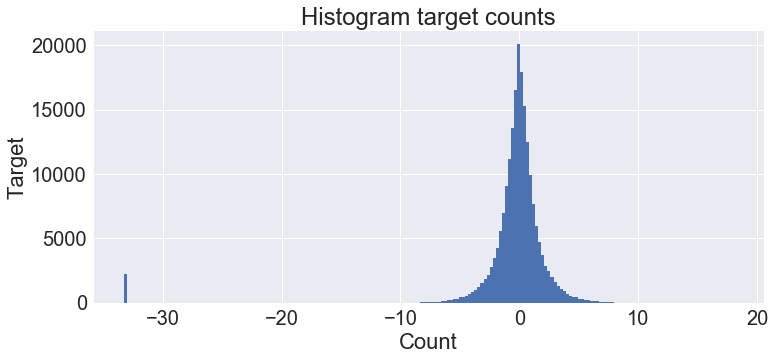

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

还是不放心，再看看“小提琴”版本：

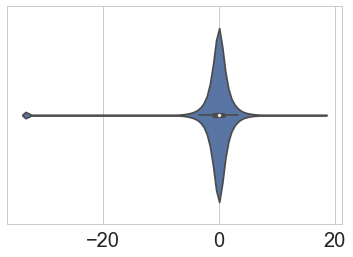

In [22]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train.target.values)
plt.show()

看起来分布还是蛮正态的，只是左侧的异常值需要处理下。

再看看卡的激活时间：

In [23]:
train.first_active_month = pd.to_datetime(train.first_active_month)
test.first_active_month = pd.to_datetime(test.first_active_month)
print(train.first_active_month.agg([np.min, np.max]))
print(test.first_active_month.agg([np.min, np.max]))

amin   2011-11-01
amax   2018-02-01
Name: first_active_month, dtype: datetime64[ns]
amin   2011-11-01
amax   2018-01-01
Name: first_active_month, dtype: datetime64[ns]


训练集和测试集的激活时间时间段都是接近，所以有理由相信，训练集和测试集是从同一个数据集随机抽取的。

现在让我们看看各种“特性”的分布:

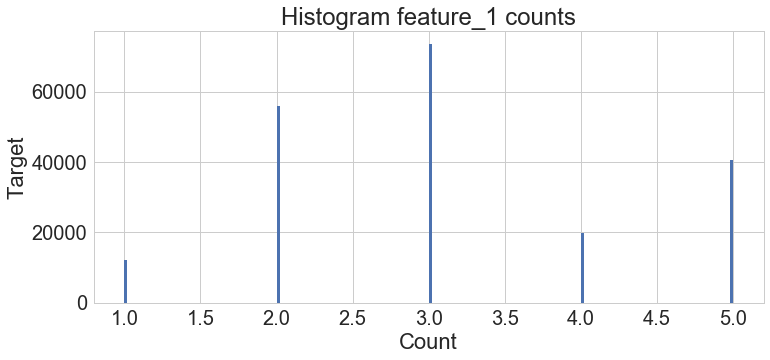

In [24]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_1.values, bins=200)
plt.title('Histogram feature_1 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

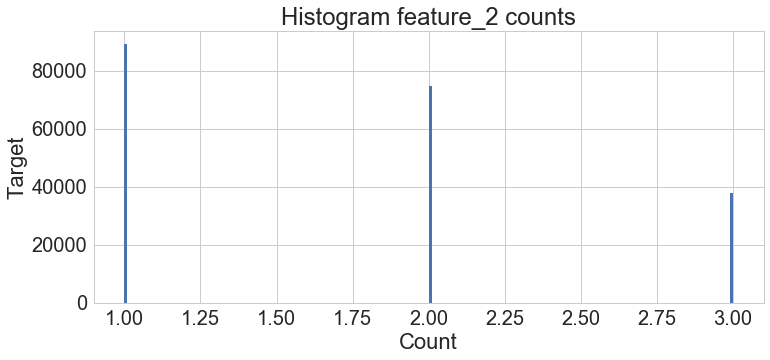

In [25]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_2.values, bins=200)
plt.title('Histogram feature_2 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

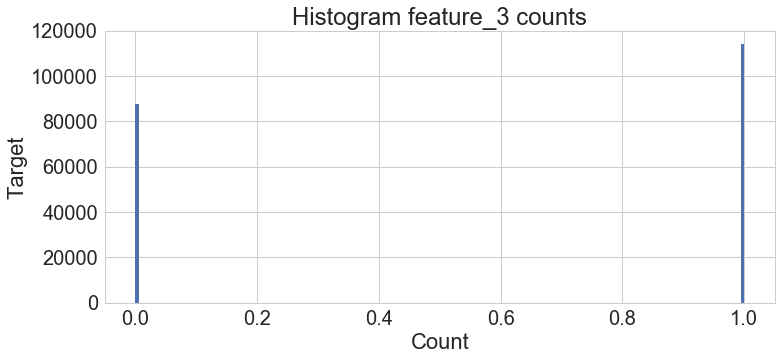

In [26]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_3.values, bins=200)
plt.title('Histogram feature_3 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

这些“特征”都是离散值，分布也算正常，后面可以给"特征"都做one hot编码，test.csv和train.csv类似，这里就不在赘述。

让我们看看训练集的特征与target相关性程度如何：

In [27]:
train.corr()["target"]

feature_1   -0.014251
feature_2   -0.006242
feature_3   -0.008125
target       1.000000
Name: target, dtype: float64

评忠诚度评分与训练集中数据没什么关系，那这个忠诚度评分怎么来的呢？交易数据中存在吗？在ELO当前的忠诚度评分指标来源应该不会这么单一，重新回顾了下赛题中有这么一段“在这场竞争中，Kagglers将开发算法，通过发现客户忠诚度的信号，识别并为个人提供最相关的机会”，所以有理由相信，ELO当前给出忠诚度评分与当前给出的数据没有关系，ELO是需要竞赛者们试图通过交易记录和商家等级找到与忠诚度评分的联系。

### 历史交易与新交易分析

In [28]:
#看看交易的购买时间数据：
hist_trans.purchase_date = pd.to_datetime(hist_trans.purchase_date)
new_trans.purchase_date = pd.to_datetime(new_trans.purchase_date)
print(hist_trans.purchase_date.agg([np.min, np.max]))
print(new_trans.purchase_date.agg([np.min, np.max]))

amin   2017-01-01 00:00:08
amax   2018-02-28 23:59:51
Name: purchase_date, dtype: datetime64[ns]
amin   2017-03-01 03:24:51
amax   2018-04-30 23:59:59
Name: purchase_date, dtype: datetime64[ns]


再看下购买时间分布：

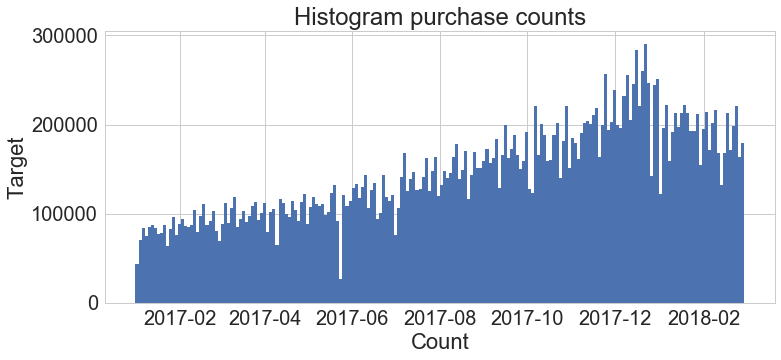

In [29]:
#历史交易时间分布
plt.figure(figsize=(12, 5))
plt.hist(hist_trans.purchase_date.values, bins=200)
plt.title('Histogram purchase counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

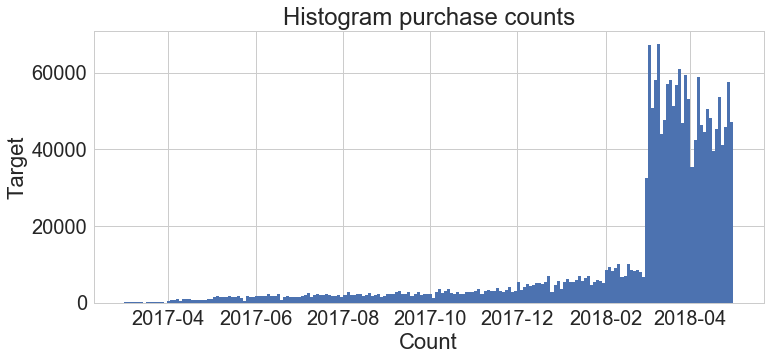

In [30]:
#新交易时间分布
plt.figure(figsize=(12, 5))
plt.hist(new_trans.purchase_date.values, bins=200)
plt.title('Histogram purchase counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

历史交易和新交易在购买时间基本一致，新交易比历史交易后移了2个月。

看看交易中卡的情况

In [31]:
hist_cardid_set = set(hist_trans.card_id)
new_cardid_set = set(new_trans.card_id)
print("历史交易数据card_id数量:{}".format( len(set(hist_cardid_set))))
print("新交易数据card_id数量:{}".format( len(set(new_cardid_set)) ))
print("新交易卡的集合是否是历史交易的卡集合的子集:{}".format(new_cardid_set.issubset(hist_cardid_set)))

历史交易数据card_id数量:325540
新交易数据card_id数量:290001
新交易卡的集合是否是历史交易的卡集合的子集:True


历史交易的用户包含新交易中用户，ELO为什么要分成两部分？也许是有意义的，可以大胆想象这些用户也许收费商家或者是做了某些测试倒流过去的。

历史交易和新交易中还有不是很明确字段month_lag，官方的给出“month lag to reference date”相对参考日期的滞后的月份，出现了一个没有任何解释参考日期，在讨论区里面参赛者们讨论了很多，有人坚信是参考日期是忠诚度评分的日期，而且给出了公式：参考日期=购买日期-month_lag, 被官方人员说”in my opinion ,it’s very useful”，心里大石头终于落下了，简单看下month_lag:

In [32]:
hist_trans.month_lag.value_counts()

-2     3857276
-1     3627430
 0     3470946
-3     3095651
-4     2639805
-5     2364790
-6     2050048
-7     1769844
-8     1427846
-9     1234724
-10    1085053
-11    1007878
-12     791973
-13     689097
Name: month_lag, dtype: int64

In [33]:
new_trans.month_lag.value_counts()

1    1027617
2     935414
Name: month_lag, dtype: int64

#### 离群点

再看下连续值购买金额是否存在离群点

In [34]:
hist_trans.purchase_amount.describe(),new_trans.purchase_amount.describe()

(count    2.911236e+07
 mean     3.640090e-02
 std      1.123522e+03
 min     -7.469078e-01
 25%     -7.203559e-01
 50%     -6.883495e-01
 75%     -6.032543e-01
 max      6.010604e+06
 Name: purchase_amount, dtype: float64, count    1.963031e+06
 mean    -5.509690e-01
 std      6.940043e-01
 min     -7.468928e-01
 25%     -7.166294e-01
 50%     -6.748406e-01
 75%     -5.816162e-01
 max      2.631575e+02
 Name: purchase_amount, dtype: float64)

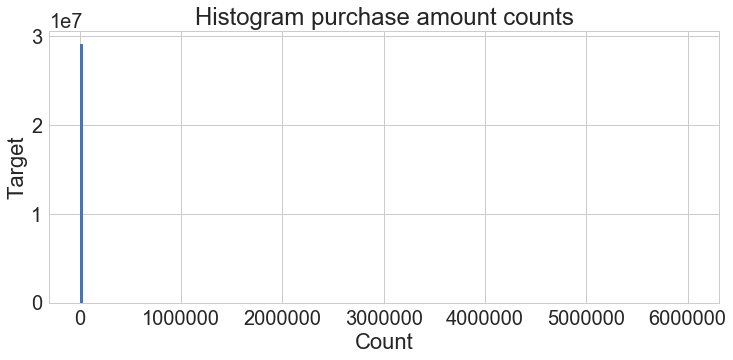

In [35]:
#历史交易购买金额分布
plt.figure(figsize=(12, 5))
plt.hist(hist_trans.purchase_amount.values, bins=200)
plt.title('Histogram purchase amount counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

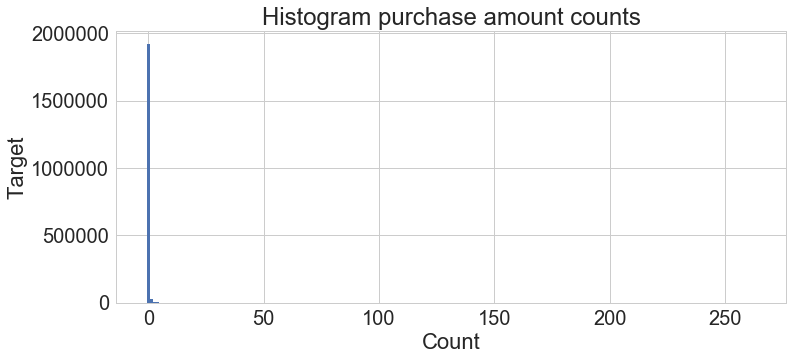

In [36]:
#新交易购买金额分布
plt.figure(figsize=(12, 5))
plt.hist(new_trans.purchase_amount.values, bins=200)
plt.title('Histogram purchase amount counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

购买金额数据存在离群值，这样会影响我们最后的结果，稍后做处理。

### 历史交易与新交易缺失值

历史交易和新交易需要做缺失值填充有category_2、category_3、merchant_id，如下：

In [37]:
#category_2数据情况查看
hist_trans.category_2.value_counts(),new_trans.category_2.value_counts()

(1.0    15177199
 3.0     3911795
 5.0     3725915
 4.0     2618053
 2.0     1026535
 Name: category_2, dtype: int64, 1.0    1058242
 3.0     289525
 5.0     259266
 4.0     178590
 2.0      65663
 Name: category_2, dtype: int64)

历史交易和新交易中category_2用最多的数值1.0进行填充。
category_3值数量统计：

In [38]:
hist_trans.category_3.value_counts(),new_trans.category_3.value_counts()

(A    15411747
 B    11677522
 C     1844933
 Name: category_3, dtype: int64, A    922244
 B    836178
 C    148687
 Name: category_3, dtype: int64)

category_3的缺失值用最多A值进行填充

In [39]:
hist_trans.merchant_id.value_counts().sort_values(ascending=False)

M_ID_00a6ca8a8a    1115097
M_ID_e5374dabc0     428619
M_ID_9139332ccc     361385
M_ID_50f575c681     183894
M_ID_fc7d7969c3     177040
M_ID_5ba019a379     170935
M_ID_f86439cec0     110341
M_ID_1f4773aa76     106476
M_ID_86be58d7e0      97259
M_ID_98b342c0e3      93394
M_ID_d855771cd9      84377
M_ID_6f274b9340      81072
M_ID_cd2c0b07e9      80179
M_ID_57df19bf28      76750
M_ID_b9dcf28cb9      75487
M_ID_b98db225f5      70384
M_ID_445742726b      68499
M_ID_2637773dd2      66836
M_ID_82a30d9203      65853
M_ID_3111c6df35      52427
M_ID_940fb4498f      51522
M_ID_c03b62d83d      50828
M_ID_820c7b73c8      47404
M_ID_b5b80addf5      45520
M_ID_a9d91682ad      43922
M_ID_7c5e93af2f      42122
M_ID_48257bb851      41150
M_ID_deb43ff012      40878
M_ID_1ac6bbc867      39678
M_ID_8fadd601d2      37900
                    ...   
M_ID_8bc7d784d1          1
M_ID_8e2ac80802          1
M_ID_db1de4791f          1
M_ID_e40c60807c          1
M_ID_a5f1064594          1
M_ID_ffc75caeed          1
M

历史交易用交易数量最多的商家编号M_ID_00a6ca8a8a来填充。

### 商家数据探索与分析

In [40]:
merchants.avg_purchases_lag3.replace(np.inf,np.nan).dropna().apply(lambda x:min(x,5237)).describe()

count    334693.000000
mean          1.421609
std          11.888937
min           0.333495
25%           0.923650
50%           1.016667
75%           1.146520
max        5237.000000
Name: avg_purchases_lag3, dtype: float64

In [41]:
merchants.avg_sales_lag3.replace(np.inf,np.nan).dropna().describe()

count    334683.000000
mean         13.832993
std        2395.489999
min         -82.130000
25%           0.880000
50%           1.000000
75%           1.160000
max      851844.640000
Name: avg_sales_lag3, dtype: float64

In [42]:
merchants.state_id.value_counts()

 9     92708
 16    33226
 15    27224
 5     23547
 19    18793
 20    15660
 4     14216
 21    13716
-1     11887
 13     9487
 7      9375
 24     8045
 12     7730
 11     7318
 22     6553
 14     6194
 2      5061
 23     4357
 18     3815
 3      3629
 10     3184
 1      2908
 8      2842
 17     1961
 6      1260
Name: state_id, dtype: int64

离群点检测

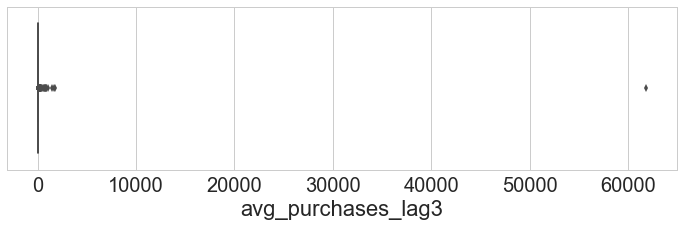

In [43]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x='avg_purchases_lag3', data=merchants)

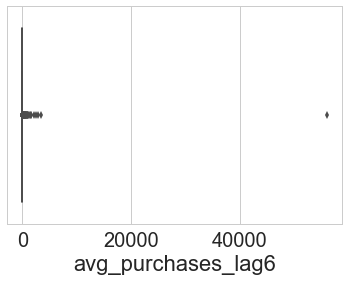

In [44]:
sns.boxplot(x='avg_purchases_lag6', data=merchants)

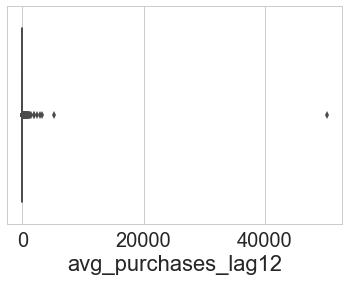

In [45]:
sns.boxplot(x='avg_purchases_lag12', data=merchants)

In [46]:
merchants.avg_purchases_lag12.replace(np.inf,np.nan).dropna().sort_values().tail(10)

43346     1248.875000
5132      1318.377778
2522      1369.285714
5816      1839.142857
4941      1878.750000
4100      2326.888889
13168     2941.142857
6470      3227.833333
15        5236.000000
235      50215.555556
Name: avg_purchases_lag12, dtype: float64

In [47]:
del merchants,hist_trans,new_trans,train,test
gc.collect()

52712

## 1.4 特征工程和预处理

### 卡相关特征

In [48]:
debug = False  #是否是测试状态
num_rows = 10000 if debug else None  #测试状态只运行10000条

# preprocessing train & test
def train_test(num_rows=None):
    # load csv
    train_df = pd.read_csv('./data/train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('./data/test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    #目标值是否是极端值
    train_df['outliers'] = 0
    train_df[train_df['target']<-30]['outliers'] = 1

    # #给测试集加上空的target
    test_df["target"] = np.nan

    # #合并
    df = train_df.append(test_df)

    #删除
    del train_df,test_df
    gc.collect()
    
    #格式转换为datatime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    #卡激活时间的季度
    df['quarter'] = df['first_active_month'].dt.quarter

    #卡激活时间月份
    df['first_active_month_num'] = df['first_active_month'].dt.month

    #卡激活时间在一年的第几周
    df['first_active_weekofyear'] = df['first_active_month'].dt.weekofyear

    #卡激活时间在一年的第几天
    df['first_active_dayofyear'] = df['first_active_month'].dt.dayofyear

    #卡激活时间的天数
    df['first_active_day'] = df['first_active_month'].dt.day

    #卡激活时间是否在周末
    df['first_active_weekend'] = (df['first_active_month'].dt.weekday >= 5).astype(int)

    #卡激活时间与当前时间的间隔
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    #卡激活时间和当前时间的间隔与feather1乘积（feather1/feather2/feather3是卡的匿名特征）
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']

    #卡激活时间和当前时间的间隔与feather2乘积
    df['days_feature2']= df['elapsed_time'] * df['feature_2']

    #卡激活时间和当前时间的间隔与feather3乘积
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    # #卡激活时间和当前时间间隔与feather1的商
    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']

    #卡激活时间和当前时间间隔与feather2的商
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']

    #卡激活时间和当前时间间隔与feather3的商
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1', 'feature_2', 'feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    # #统计特征
    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum'] / 3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
    return df

with timer("trian & test"):
    df = train_test(num_rows)

Train samples: 201917, test samples: 123623
trian & test - done in 4s


### 历史交易相关特征

In [49]:
#提取交易相关特征
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('./data/historical_transactions.csv', nrows=num_rows)
    
    # 缺失值填充
    hist_df['category_2'].fillna(1.0, inplace=True)
    hist_df['category_3'].fillna('A', inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    hist_df['installments'].replace(-1, np.nan, inplace=True)
    hist_df['installments'].replace(999, np.nan, inplace=True)

    # trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A': 0, 'B': 1, 'C': 2})
    
    #格式转为datetime
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])

    #交易时间在那一年
    hist_df['year'] = hist_df['purchase_date'].dt.year  #cs

    #交易时间在一年的第几季度
    hist_df['quarter'] = hist_df['purchase_date'].dt.quarter
    
    #交易时间在一年的第几月 
    hist_df['month'] = hist_df['purchase_date'].dt.month

    #交易时间在一年的第几周
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear

    #交易时间的天数
    hist_df['day'] = hist_df['purchase_date'].dt.day

    #交易时间的小时
    hist_df['hour'] = hist_df['purchase_date'].dt.hour

    #交易时间在星期几
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday

    #交易时间是否是周末
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >= 5).astype(int)

    #分期还款金额（购买金额除以分期次数）
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    #距离2017年圣诞节前100天内的多少天购买
    hist_df['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2017年狂欢节前100天内的多少天购买（一年一度购物狂欢）
    hist_df['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2017年母亲节前100天内的多少天购买
    hist_df['Mothers_Day_2017'] = (pd.to_datetime('2017-05-13') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2017年父亲节前100天内的多少天购买
    hist_df['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2017年儿童节前100天内的多少天购买
    hist_df['Children_day_2017'] = (pd.to_datetime('2017-10-12') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2017年情人节前100天内的多少天购买
    hist_df['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #距离2018年母亲节前100天内的多少天购买
    hist_df['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days) // 30
    hist_df['month_diff'] += hist_df['month_lag']

    hist_df['duration'] = hist_df['purchase_amount'] * hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount'] / hist_df['month_diff']

    #减少内存使用
    hist_df = reduce_mem_usage(hist_df)

    #历史数据统计特征
    col_unique = ['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'year', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['sum', 'max', 'min','mean', 'var', 'skew']  #cs
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['month_diff'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean']  # overwrite
    aggs['weekday'] = ['mean']  # overwrite
    aggs['day'] = ['nunique', 'mean', 'min']  # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size', 'count']
    aggs['price'] = ['sum', 'mean', 'max', 'min', 'var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration'] = ['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio'] = ['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2', 'category_3']:
        hist_df[col + '_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col + '_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col + '_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col + '_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_' + c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max'] - hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff'] / hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today() - hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df

with timer("history transactions"):
    hist_tran = historical_transactions(num_rows)
    df = pd.merge(df, hist_tran, on='card_id', how='outer')

Memory usage after optimization is: 1915.70 MB
Decreased by 73.9%
Memory usage after optimization is: 58.99 MB
Decreased by 57.7%
history transactions - done in 1009s


### 新交易相关特征

In [50]:
# 处理新交易相关特征
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv('./data/new_merchant_transactions.csv', nrows=num_rows)

    # 缺失值处理
    new_merchant_df['category_2'].fillna(1.0, inplace=True)
    new_merchant_df['category_3'].fillna('A', inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan, inplace=True)
    new_merchant_df['installments'].replace(999, np.nan, inplace=True)

    # trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A': 0, 'B': 1, 'C': 2}).astype(int)

    # 时间特征
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['year'] = new_merchant_df['purchase_date'].dt.year  # cs
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >= 5).astype(int)

    # 附加特征
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #距离2017年圣诞节前100天内的多少天购买
    new_merchant_df['Christmas_Day_2017'] = (
    pd.to_datetime('2017-12-25') - new_merchant_df['purchase_date']).dt.days.apply(
        lambda x: x if x > 0 and x < 100 else 0)
    #距离2017年儿童节前100天内的多少天购买  
    new_merchant_df['Children_day_2017'] = (
    pd.to_datetime('2017-10-12') - new_merchant_df['purchase_date']).dt.days.apply(
        lambda x: x if x > 0 and x < 100 else 0)
    #距离2017年狂欢节前100天内的多少天购买（一年一度购物狂欢）  

    new_merchant_df['Black_Friday_2017'] = (
    pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(
        lambda x: x if x > 0 and x < 100 else 0)

    #距离2018年母亲节前100天内的多少天购买  
    new_merchant_df['Mothers_Day_2018'] = (
    pd.to_datetime('2018-05-13') - new_merchant_df['purchase_date']).dt.days.apply(
        lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days) // 30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # 附加特征
    new_merchant_df['duration'] = new_merchant_df['purchase_amount'] * new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount'] / new_merchant_df['month_diff']

    # 降低内存使用量
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique = ['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'year', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['installments'] = ['sum', 'max', 'min', 'mean', 'var', 'skew']
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'skew']
    aggs['month_diff'] = ['mean', 'var', 'skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size', 'count']
    aggs['price'] = ['mean', 'max', 'min', 'var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration'] = ['mean', 'min', 'max', 'var', 'skew']
    aggs['amount_month_ratio'] = ['mean', 'min', 'max', 'var', 'skew']

    for col in ['category_2', 'category_3']:
        new_merchant_df[col + '_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col + '_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col + '_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col + '_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col + '_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # 改变列名
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_' + c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (
    new_merchant_df['new_purchase_date_max'] - new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff'] / new_merchant_df[
        'new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (
    datetime.datetime.today() - new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (
    datetime.datetime.today() - new_merchant_df['new_purchase_date_min']).dt.days

    # 降低内存使用量
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

with timer("new merchants"):
    new_tran = new_merchant_transactions(num_rows)
    df = pd.merge(df, new_tran, on='card_id', how='outer')

Memory usage after optimization is: 121.69 MB
Decreased by 72.0%
Memory usage after optimization is: 47.02 MB
Decreased by 57.7%
new merchants - done in 619s


### 附加特征

In [51]:
def additional_features(df):
    #历史交易中用户第一次购买与卡激活时间的间隔天数
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    #历史交易中用户最后一次购买与卡激活时间的间隔天数
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    #新交易中用户第一次购买与卡激活时间的间隔天数
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    #新交易中用户最后一次购买与卡激活时间的间隔天数
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features = ['hist_purchase_date_max', 'hist_purchase_date_min',
                     'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9
    #
    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
    #历史交易和新交易购物金额统计特征
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
    #month_diff统计特征
    df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
    #month lag 统计特征
    df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
    
    df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
    #分期付款统计特征
    df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']
    #购物金额与分期付款总额之比
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
    df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
    df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max'] = df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df

df = additional_features(df)

### 特征筛选

#### 剔除共线性特征

In [52]:
# def remove_collinear_features(x, threshold):
#     '''
#     Objective:
#         Remove collinear features in a dataframe with a correlation coefficient
#         greater than the threshold. Removing collinear features can help a model
#         to generalize and improves the interpretability of the model.
        
#     Inputs: 
#         threshold: any features with correlations greater than this value are removed
    
#     Output: 
#         dataframe that contains only the non-highly-collinear features
#     '''
    
#     # Dont want to remove correlations between Energy Star Score
#     y = x['target']
#     x = x.drop(columns = ['target'])
    
#     # Calculate the correlation matrix
#     corr_matrix = x.corr()
#     iters = range(len(corr_matrix.columns) - 1)
#     drop_cols = []

#     # Iterate through the correlation matrix and compare correlations
#     for i in iters:
#         for j in range(i):
#             item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
#             col = item.columns
#             row = item.index
#             val = abs(item.values)
            
#             # If correlation exceeds the threshold
#             if val >= threshold:
#                 # Print the correlated features and the correlation value
#                 # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
#                 drop_cols.append(col.values[0])

#     # Drop one of each pair of correlated columns
#     drops = set(drop_cols)
#     x = x.drop(columns = drops)

#     print(drops)
#     # Add the score back in to the data
#     x['target'] = y
               
#     return x

# with timer('delete collinearity features'):
#     df = remove_collinear_features(df, 0.6)

### 保存结果，建模的时候用

In [54]:
with timer('split train & test'):
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    train_df.to_csv('data/output/3/last_train_df.csv', index = False)
    test_df.to_csv('data/output/3/last_test_df.csv', index = False)

split train & test - done in 78s
